# TRY TO UNDERSTAND WHERE TO PUT PREPROCESS BASED ON WHO IS CALLING IT
the neural network needs it in order to feed itself  
the agent needs it because it calls the neural network  
so i guess the neural network needs it

# Imports

In [516]:
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld, OvercookedState
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.agents.agent import Agent, AgentPair, RandomAgent
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from typing import Tuple, List, Dict

# Useful classes 

Policy class: NN for computing the probability distribution of the actions to take.

In [517]:
class Policy(Model):
    def __init__(self, input_shape, num_actions, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(128, activation='relu')
        self.policy_a = layers.Dense(self.num_actions, activation='softmax', name="policy_a")
        self.policy_b = layers.Dense(self.num_actions, activation='softmax', name="policy_b")
    
    def preprocess(self, obs):
        agent_1_obs = obs['both_agent_obs'][0]
        agent_2_obs = obs['both_agent_obs'][1]
        return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
    
    def process_gradient(self, gradient, delta):
        processed_gradient = []
        for grad in gradient:
            if tf.rank(grad) == 2 and grad.shape[0] == 1:
                processed_gradient.append(-delta*tf.squeeze(grad))
            else:
                processed_gradient.append(grad)
        return gradient
        

    def call(self, obs, training=False):
        x = self.preprocess(obs)
        x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        policy_a = self.policy_a(x)
        policy_b = self.policy_b(x)
        return (policy_a, policy_b)

    def build_model(self):
        # you can find a sketch on Understanding overcooked.ipynb
        pass    
    
    def train_step(self, delta, obs: Tuple, action: Tuple[int,int]):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs, training=True)
            # HERE need to compute the log probabilities
            log_pi = tf.math.log(pi)
            pi_a = log_pi[0][..., action[0]] + log_pi[1][..., action[1]] # π(A|S), computing the sum of the probability of the best actions
        
        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        processed_gradient = self.process_gradient(grad_pi_a, delta)
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))

ValueFunctionApproximator class: NN for approximating the value function of a given state.

In [518]:
class ValueFunctionApproximator(Model):
    def __init__(self, input_shape, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(128, activation='relu')
        self.value_function = layers.Dense(1, activation='relu', name="value_function")
    
    def preprocess(self, obs):
        agent_1_obs = obs['both_agent_obs'][0]
        agent_2_obs = obs['both_agent_obs'][1]
        return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
    
    def process_gradient(self, gradient, delta):
        processed_gradient = []
        for grad in gradient:
            if tf.rank(grad) == 2 and grad.shape[0] == 1:
                processed_gradient.append(-delta*tf.squeeze(grad))
            else:
                processed_gradient.append(grad)
        return gradient

    def call(self, obs: Tuple, training=False):
        x = self.preprocess(obs)
        x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        value_function = self.value_function(x)
        return value_function

    def build_model(self):
        # you can find a sketch on Understanding overcooked.ipynb
        pass   
    
    def train_step(self, delta, obs: Tuple):
        # update w with w + alpha_w*delta*grad_v^(St)
        with tf.GradientTape() as tape:
            state_value = self.call(obs, training=True)
        
        grad_state_value = tape.gradient(state_value, self.trainable_weights)
        processed_gradient = self.process_gradient(grad_state_value, delta)
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))


Agent class: inherits from Agent class found in agent.py

In [550]:
class MyAgent(Agent):
    """
    This class is more a couple of actors since we use shared networks and the output are 2!!!
    For now let's treat it like a single player identified by self.index
    """
    def __init__(self, actor, critic, idx, base_env: OvercookedEnv, epsilon = 0.1):
        super().__init__()
        self.actor = actor
        self.critic = critic
        self.idx = idx
        if not self.idx in [0,1]:
            raise AssertionError("The index of the agent must be either 0 or 1!")
        self.base_env = base_env
        self.epsilon = epsilon

    def action(self, obs):
        """
        obs: preprocessed observation (or overcookedstate)
        We want to output the action given the state. can use a NN!
        should return a tuple (Action, Dict)
        Dict should contain info about the action ('action_probs': numpy array)
        """
        if isinstance(obs, OvercookedState):
            # this is useful for translating the OvercookedState 
            # into observation that can be fed into the NN.
            state = obs
            obs_from_state = self.base_env.featurize_state_mdp(state)
            obs = {'both_agent_obs': obs_from_state, 'overcooked_state': state}
    
        action_probs = self.actor.call(obs)[self.idx].numpy()
        if np.random.random() > self.epsilon: 
            action = Action.argmax(action_probs) # greedy selection
        else:
            action_idx = np.random.choice(range(0,6), size=1)[0]
            action = Action.INDEX_TO_ACTION[action_idx] # random exploration
        return (action, {'action_probs': action_probs})

    def actions(self, obss):
        """
        Look at the documentation of the Agent class
        """
        pass

    def update(self, obs, reward):
        """
        What do we need to update?
        """
        pass

Let's define a useful function for preprocessing the observation in order to feed our neural networks

In [532]:
# def preprocess(obs):
#     agent_1_obs = obs['both_agent_obs'][0]
#     agent_2_obs = obs['both_agent_obs'][1]
#     return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))

# Let's start coding!

Let's define our environment:

In [551]:
number_of_frames = 1000
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

Let's instantiate our networks and the hyperparameters:

In [552]:
number_of_episodes = 2
alpha_w = 1e-3
alpha_t = 1e-3
critic_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [553]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

shared_critic = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_optimizer
    )

Let's instantiate our agents:

In [554]:
agent_1 = MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx=0,
    base_env=base_env
)
agent_2 = MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx=1,
    base_env=base_env
)

Let's define our training loop! Let's go for now for a bootstrapping method.

In [548]:
for episode in range(number_of_episodes):
    t = 0
    obs = env.reset()
    done = False
    while not done:
        action1 = agent_1.action(obs)
        action2 = agent_2.action(obs)
        player_1_action = Action.ACTION_TO_INDEX[action1[0]]
        player_2_action = Action.ACTION_TO_INDEX[action2[0]]
        action = (player_1_action, player_2_action)

        new_obs, reward, done, env_info = env.step(action)
        shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.
        total_reward = reward + shaped_reward
        # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
        if done:
            delta = reward - shared_critic.call(obs)
        else:
            delta = reward + shared_critic.call(new_obs) - shared_critic.call(obs)
        # update w with w + alpha_w*delta*grad_v^(St)
        shared_critic.train_step(delta, obs)        
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        shared_actor.train_step(delta, obs, action)
        # update state (obs = new_obs) 
        obs = new_obs  

        # think about training the critic by itself for a while
        t += 1
        
    print(f"Episode terminated at timestep {t}")

KeyboardInterrupt: 

final frame: 


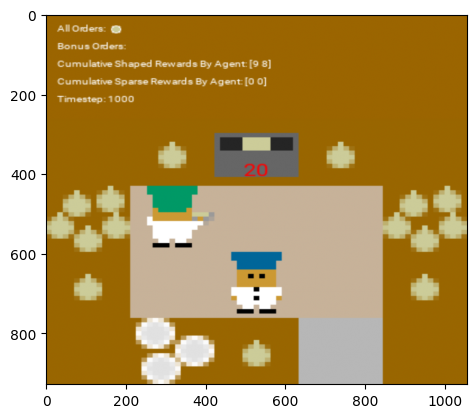

In [398]:
print("final frame: ")
render = env.render() / 255.0
plt.imshow(render)
plt.show()

In [555]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": 400})

ap = AgentPair(MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx=0,
    base_env=base_env,
    epsilon=0.5
), MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx=0,
    base_env=base_env,
    epsilon=0.5
))

trajs = ae.evaluate_agent_pair(ap, 10)
# trajs = ae.evaluate_human_model_pair(1)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

# Using trajectories
 When evaluating trajectory of my agents, the agents are fed with the overcooked state.  
 Since my agent use the "both_agent_obs", i can convert the overcooked state in "both_agent_obs" through base_env.featurize_state_mdp(state).  
 The problem here is that i need to pay attention to the index since this method returns always in the POV of agent 0.  
 What i can do is to retrieve the index with env.agent_idx and i will have the following equality:  
 base_env.featurize_state_mdp(state)[0] == obs['both_agent_obs'][env.agent_idx]  
 I need to find a way to include the environment on my agent class and be able to call the agent_idx in order to preprocess the state and use the right order. 
 During testing this should not be a huge problem since our network should be able to generalize the position... let's do without it!

In [ ]:
obs = env.reset()
state = obs['overcooked_state']
transformed_obs = base_env.featurize_state_mdp(state)
print(env.agent_idx)
transformed_obs[env.agent_idx] == obs['both_agent_obs'][0]


0


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [500]:
state.to_dict()

{'players': [{'position': (1, 2), 'orientation': (0, -1), 'held_object': None},
  {'position': (3, 1), 'orientation': (0, -1), 'held_object': None}],
 'objects': [],
 'bonus_orders': [],
 'all_orders': [{'ingredients': ('onion', 'onion', 'onion')}],
 'timestep': 0}

In [514]:
type(ae.env)

overcooked_ai_py.mdp.overcooked_env.OvercookedEnv